## POOL AXS_WETH
**Pool Characteristics: Low capitalization, low transaction frequency**

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [13]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [14]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [15]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [25]:
EXPERIMENT_ID = 120

X_NAME = 'AXS'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [26]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [27]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [28]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [29]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [30]:
swaps0_df.head()

id token_in token_out  token_in_amount  token_out_amount_min  \
0   0     WETH       AXS         1.000000              0.000000   
1   2     WETH       AXS         0.400000           -118.390840   
2   3     WETH       AXS       200.000000          -1694.606685   
3   4      AXS      WETH       269.176166             -0.826144   
4   5     WETH       AXS         0.500000           -128.373546   

   token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0          0.000000         NaN            NOT_REACHED                NaN   
1        118.390840    0.001600          MITIGATOR_OFF                NaN   
2       1694.606685    0.800000          MITIGATOR_OFF                NaN   
3        171.121491    0.684486          MITIGATOR_OFF                NaN   
4          4.678589    0.002000          MITIGATOR_OFF                NaN   

   oracle_price  out_amount_diff  slice_factor  slice_factor_curve  \
0           NaN              NaN           NaN                 NaN   
1           NaN              NaN           NaN                 NaN   
2           NaN              NaN           NaN                 NaN   
3           NaN              NaN           NaN                 NaN   
4           NaN              NaN           NaN                 NaN   

                status  block_number     block_timestamp  \
0  NOT_ENOUGH_RESERVES     108000408 2021-05-03 01:42:22   
1              SUCCESS     108000409 2021-05-03 01:42:37   
2              SUCCESS     108000410 2021-05-03 01:42:52   
3              SUCCESS     108000410 2021-05-03 01:42:52   
4              SUCCESS     108000410 2021-05-03 01:42:52   

  transaction_timestamp  txd  \
0   2021-05-03 01:42:22    0   
1   2021-05-03 01:42:28    2   
2   2021-05-03 01:42:48    3   
3   2021-05-03 01:42:48    4   
4   2021-05-03 01:42:48    5   

                                              sender  \
0  0x4bd0e1ac628e46befe15c93c7f5125146dbcb3d39dec...   
1  0x0439383f710521f46e1af7355efc9462c0b002dec9c5...   
2  0xfdbe038eb39530db99d68b67279c5f6b809b989fad5d...   
3  0xe101177c2a1cf0a22dbec680da739e5b4f3dad5e5dfe...   
4  0x64dca22095c42da4b1a21e6bf6fa3774bd2ec53ae1c6...   

                                           to  sequence_swap_cnt  attempt_cnt  \
0  0x27f9adb26d532a41d97e00206114e429ad58c679                  0            0   
1  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0            0   
2  0xd78a3280085ee846196cb5fab7d510b279486d44                  0            0   
3  0x27f9adb26d532a41d97e00206114e429ad58c679                  0            0   
4  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0            0   

                      desired_token_in_amount  transaction_id  \
0  0x27f9adb26d532a41d97e00206114e429ad58c679               0   
1  0x9108048f5ef19c64d00adda718906990b53d02cd               2   
2  0xf6da21e95d74767009accb145b96897ac3630bad               3   
3  0x27f9adb26d532a41d97e00206114e429ad58c679               4   
4  0x78a622d8e6fd0fb9c7ada77b6bfb83bf84a2876a               5   

   reserve_X_before  reserve_Y_before      k_before  \
0          0.000000          0.000000      0.000000   
1       1866.449528          5.847000  10913.130389   
2       1748.058688          6.245400  10917.325729   
3         53.452003        205.445400  10981.468133   
4        322.628169         33.639423  10853.025462   

   price_X_cumulative_before  price_Y_cumulative_before  \
0                          0                          0   
1                          0                          0   
2                          0                       4788   
3                          0                       8986   
4                          0                       8986   

   is_volatility_mitigator_on_before    reserve_X   reserve_Y             k  \
0                              False     0.000000    0.000000      0.000000   
1                              False  1748.058688    6.245400  10917.325729   
2                       

In [31]:
swaps0_df.status.value_counts()

SUCCESS                4586
NOT_ENOUGH_RESERVES       1
Name: status, dtype: int64

In [32]:
swaps0_df

id token_in token_out  token_in_amount  token_out_amount_min  \
0        0     WETH       AXS         1.000000              0.000000   
1        2     WETH       AXS         0.400000           -118.390840   
2        3     WETH       AXS       200.000000          -1694.606685   
3        4      AXS      WETH       269.176166             -0.826144   
4        5     WETH       AXS         0.500000           -128.373546   
...    ...      ...       ...              ...                   ...   
4582  4692     WETH       AXS         0.198353             -6.318525   
4583  4695      AXS      WETH         1.100000             -0.034524   
4584  4696      AXS      WETH         5.967619             -0.182401   
4585  4697      AXS      WETH         1.000000             -0.029773   
4586  4698     WETH       AXS         0.232592             -7.472206   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0             0.000000         NaN            NOT_REACHED                NaN   
1           118.390840    0.001600          MITIGATOR_OFF                NaN   
2          1694.606685    0.800000          MITIGATOR_OFF                NaN   
3           171.121491    0.684486          MITIGATOR_OFF                NaN   
4             4.678589    0.002000          MITIGATOR_OFF                NaN   
...                ...         ...                    ...                ...   
4582          6.318525    0.000793          MITIGATOR_OFF                NaN   
4583          0.034524    0.000138          MITIGATOR_OFF                NaN   
4584          0.182401    0.000730          MITIGATOR_OFF                NaN   
4585          0.029773    0.000119          MITIGATOR_OFF                NaN   
4586          7.472206    0.000930          MITIGATOR_OFF                NaN   

      oracle_price  out_amount_diff  slice_factor  slice_factor_curve  \
0              NaN              NaN           NaN                 NaN   
1              NaN              NaN           NaN                 NaN   
2              NaN              NaN           NaN                 NaN   
3              NaN              NaN           NaN                 NaN   
4              NaN              NaN           NaN                 NaN   
...            ...              ...           ...                 ...   
4582           NaN              NaN           NaN                 NaN   
4583           NaN              NaN           NaN                 NaN   
4584           NaN              NaN           NaN                 NaN   
4585           NaN              NaN           NaN                 NaN   
4586           NaN              NaN           NaN                 NaN   

                   status  block_number     block_timestamp  \
0     NOT_ENOUGH_RESERVES     108000408 2021-05-03 01:42:22   
1                 SUCCESS     108000409 2021-05-03 01:42:37   
2                 SUCCESS     108000410 2021-05-03 01:42:52   
3                 SUCCESS     108000410 2021-05-03 01:42:52   
4                 SUCCESS     108000410 2021-05-03 01:42:52   
...                   ...           ...                 ...   
4582              SUCCESS     109179485 2021-11-23 18:31:37   
4583              SUCCESS     109180402 2021-11-23 22:20:52   
4584              SUCCESS     109180739 2021-11-23 23:45:07   
4585              SUCCESS     109180858 2021-11-24 00:14:52   
4586              SUCCESS     109181777 2021-11-24 04:04:37   

     transaction_timestamp   txd  \
0      2021-05-03 01:42:22     0   
1      2021-05-03 01:42:28     2   
2      2021-05-03 01:42:48     3   
3      2021-05-03 01:42:48     4   
4      2021-05-03 01:42:48     5   
...                    ...   ...   
4582   2021-11-23 18:31:35  4692   
4583   2021-11-23 22:20:45  4695   
4584   2021-11-23 23:45:07  4696   
4585   2021-11-24 00:14:44  4697   
4586   2021-11-24 04:04:25  4698   

                                                 sender  \
0     0x4bd0e1ac628e46befe15c93c7f5125146dbcb3d39dec... 

In [33]:
swaps1_df.status.value_counts()

SUCCESS                             4456
BLOCKED_BY_VOLATILITY_MITIGATION     130
NOT_ENOUGH_RESERVES                    1
Name: status, dtype: int64

In [34]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.028340963592762156


In [35]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                4580
CANT_CONSULT_ORACLE       6
NOT_REACHED               1
Name: mitigator_check_status, dtype: int64

In [36]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.0013080444735120995


In [37]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    39
CLIPPED     1
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    39
CLIPPED     1
Name: status, dtype: int64


### Table of transactions blocked by Volatility Mitigation Mechanism

In [38]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before']]

token_in token_out  token_in_amount  token_out_amount  slice_factor  \
2        WETH       AXS       200.000000       1694.606685         100.0   
8         AXS      WETH      1453.949686          2.934657          85.0   
197       AXS      WETH        14.088301          0.070671          32.0   
202       AXS      WETH        14.194613          0.081911          32.0   
207       AXS      WETH        18.688968          0.104680          34.0   
211       AXS      WETH        16.685140          0.103363          28.0   
217       AXS      WETH        26.240996          0.135959          43.0   
222       AXS      WETH        25.609581          0.155279          41.0   
226       AXS      WETH        24.048222          0.177300          42.0   
230       AXS      WETH        22.946799          0.198889          44.0   
236       AXS      WETH        20.115300          0.190280          36.0   
244       AXS      WETH        12.362731          0.139533          46.0   
249       AXS      WETH        17.205360          0.205700          70.0   
253       AXS      WETH        17.673598          0.245662          80.0   
256       AXS      WETH        23.543779          0.208005          48.0   
260       AXS      WETH        23.017319          0.234918          51.0   
263       AXS      WETH        22.624717          0.260638          54.0   
268       AXS      WETH        25.354192          0.261169          47.0   
270       AXS      WETH        15.099332          0.184222          28.0   
277       AXS      WETH        22.396411          0.256721          38.0   
280       AXS      WETH        18.698970          0.239666          33.0   
283       AXS      WETH        23.201840          0.299513          43.0   
286       AXS      WETH        20.143463          0.237637          28.0   
287       AXS      WETH        26.138018          0.264369          31.0   
291       AXS      WETH        33.230313          0.368736          43.0   
293       AXS      WETH        28.980494          0.348658          39.0   
297       AXS      WETH        20.498357          0.295467          29.0   
302       AXS      WETH        33.704880          0.349661          42.0   
305       AXS      WETH        29.941450          0.352042          40.0   
307       AXS      WETH        38.197152          0.438992          52.0   
312       AXS      WETH        30.306233          0.431114          45.0   
315       AXS      WETH        33.746778          0.505131          53.0   
321       AXS      WETH        21.325997          0.238340          26.0   
324       AXS      WETH        32.312796          0.359900          42.0   
328       AXS      WETH        34.031614          0.414030          47.0   
331       AXS      WETH        47.928607          0.545128          68.0   
337       AXS      WETH        37.018949          0.542908          58.0   
339       AXS      WETH        26.132674          0.448013          42.0   
343       AXS      WETH        37.842529          0.627716          64.0   
347       AXS      WETH        63.017041          0.891017         100.0   
352       AXS      WETH        27.161570          0.597437          51.0   
354       AXS      WETH        61.156160          0.979313         100.0   
359       AXS      WETH        27.496660          0.600026          44.0   
362       AXS      WETH        41.492822          0.814176          68.0   
367       AXS      WETH        25.870167          0.644882          44.0   
370       AXS      WETH        33.824630          0.808319          60.0   
372       AXS      WETH        21.842454          0.619974          39.0   
374       AXS      WETH        93.887617          1.402068         100.0   
375      WETH       AXS         0.053290         11.116221           2.0   
376      WETH       AXS         0.059255         12.339817           2.0   
377       AXS      WETH        57.140912          0.245773           8.0   
378      WETH       AXS         0.024594          5.1

Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

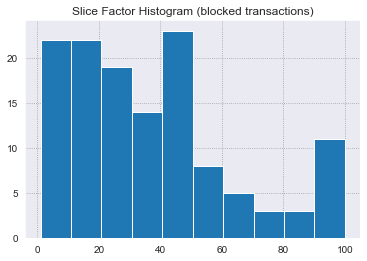

In [39]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

**The majority of the transactions blocked by the vm had a slice factor less than 50, meaning that the token_out amount would be less than 50% of the remaning reserves after the swap for them**

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

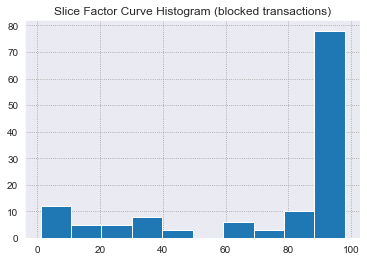

In [40]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

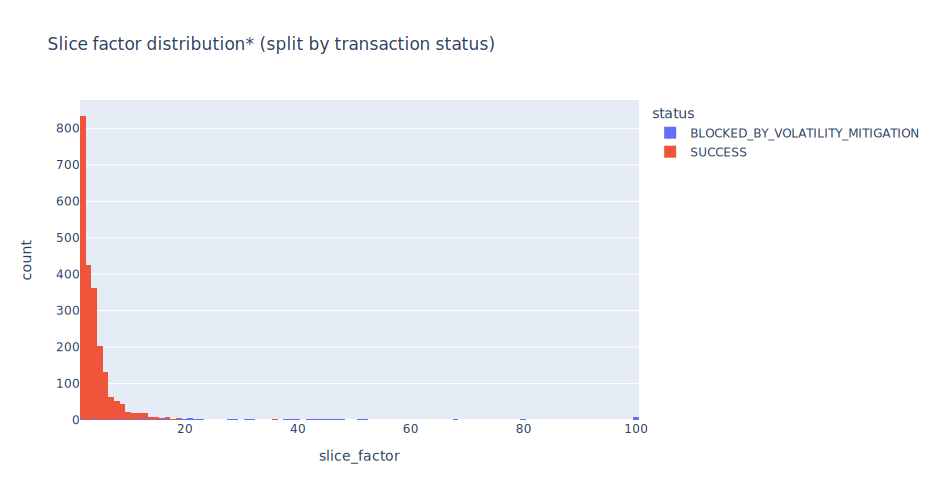

In [41]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor >= 2], x="slice_factor", color="status",
                  title='Slice factor distribution* (split by transaction status)', width=950, height=500).update_xaxes(categoryorder='total descending')
fig.show()

\**In order to better visualize the blocked transactions distribution, only the swaps with a slice_factor greater than 2 are considered in the above plot*

In [42]:
swaps1_df[(swaps1_df.status != 'SUCCESS') & (swaps1_df.slice_factor < 2)]

id token_in token_out  token_in_amount  token_out_amount_min  \
378  406     WETH       AXS         0.024594             -5.171937   
379  407     WETH       AXS         0.020000             -4.211295   
385  413     WETH       AXS         0.018220             -3.838332   
389  417     WETH       AXS         0.030251             -6.351386   
392  420     WETH       AXS         0.002980             -0.630555   

     token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
378          5.171937         NaN                CHECKED           0.996544   
379          4.211295         NaN                CHECKED           0.935176   
385          3.838332         NaN                CHECKED           1.050942   
389          6.351386         NaN                CHECKED           1.755275   
392          0.630555         NaN                CHECKED           0.176230   

     oracle_price  out_amount_diff  slice_factor  slice_factor_curve  \
378  4.051954e+19            135.0           1.0                 1.0   
379  4.675880e+19            127.0           1.0                 1.0   
385  5.768209e+19            114.0           1.0                 1.0   
389  5.802351e+19            113.0           1.0                 1.0   
392  5.913439e+19            112.0           1.0                 1.0   

                               status  block_number     block_timestamp  \
378  BLOCKED_BY_VOLATILITY_MITIGATION     108127321 2021-05-25 02:30:37   
379  BLOCKED_BY_VOLATILITY_MITIGATION     108127508 2021-05-25 03:17:22   
385  BLOCKED_BY_VOLATILITY_MITIGATION     108127869 2021-05-25 04:47:37   
389  BLOCKED_BY_VOLATILITY_MITIGATION     108128199 2021-05-25 06:10:07   
392  BLOCKED_BY_VOLATILITY_MITIGATION     108128280 2021-05-25 06:30:22   

    transaction_timestamp  txd  \
378   2021-05-25 02:30:37  406   
379   2021-05-25 03:17:22  407   
385   2021-05-25 04:47:24  413   
389   2021-05-25 06:10:02  417   
392   2021-05-25 06:30:19  420   

                                                sender  \
378  0x0d7de177635cdec9abdde45eda6b837bfbd419c26dcc...   
379  0x85d732dbe481b9a7aa0291bb6f60384ab294d88ad87f...   
385  0x3095ab8075a67039adabccba9e16f7da555fca2c2948...   
389  0x7c223ecccbf75f543dac0fdb9d758f0f727426b943a3...   
392  0xd1486569c141d2b5472a4642c3d7cf29f1dd7211a3a4...   

                                             to  sequence_swap_cnt  \
378  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0   
379  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0   
385  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0   
389  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0   
392  0x7a250d5630b4cf539739df2c5dacb4c659f2488d                  0   

     attempt_cnt                     desired_token_in_amount  transaction_id  \
378            0  0x82c4e365254fac6021869bc5b791b1aeed0185a7             406   
379            0  0x0b2a120714d7d3295e3dd1de183ef5234517b3f5             407   
385            0  0x18eb969f38d82d42027b56813a98d5ea1840c5fb             413   
389            0  0xdd8e52785fd0d464fc4831699f20320f9db6592b             417   
392            0  0x3fd7ab9ddad54c1ac45465b795552b64d7b15400             420   

     reserve_X_before  reserve_Y_before     k_before  \
378        743.872037          3.477619  2586.903895   
379        743.872037          3.477619  2586.903895   
385        743.872037          3.477619  2586.903895   
389        743.872037          3.477619  2586.903895   
392        743.872037          3.477619  2586.903895   

     price_X_cumulative_before  price_Y_cumulative_before  \
378          28054361586339130                  453679806   
379          28054361586339140                  454119376   
385          28054361586339176                  455781400   
389          28054361586339194                  456580326   
392          28054361586339207                  457177114   

     is_volatility_mitigator_on_before   reserve_X  reserve_Y     

In [43]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram', width=950, height=500).update_xaxes(categoryorder='total descending')
fig.show("notebook")

**The price difference with the one obtained from oracle for the majority of blocked transactions is greater by 30%, even though there are some cases where the difference is only about 10%. The number of successful transactions with a significant  out_amount_diff has decreased**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

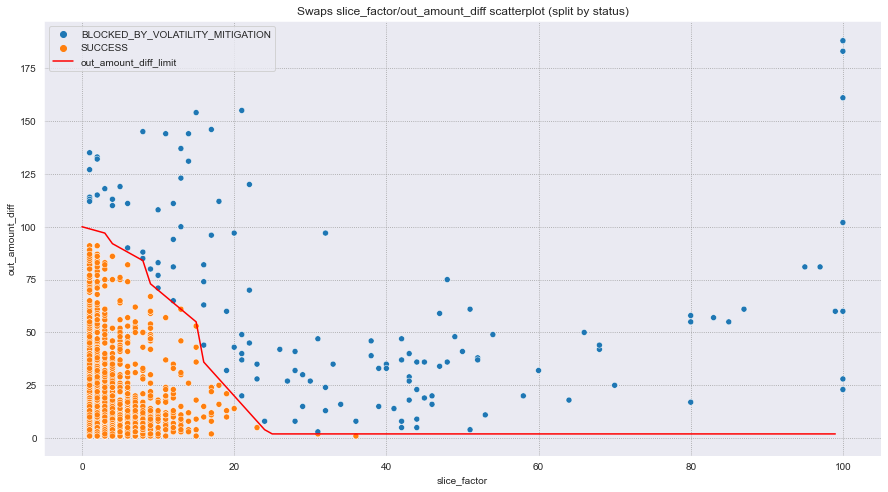

In [44]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

It can be observed that there are quite a lot of swaps lying right near the border.


In [45]:
swaps0_df

id token_in token_out  token_in_amount  token_out_amount_min  \
0        0     WETH       AXS         1.000000              0.000000   
1        2     WETH       AXS         0.400000           -118.390840   
2        3     WETH       AXS       200.000000          -1694.606685   
3        4      AXS      WETH       269.176166             -0.826144   
4        5     WETH       AXS         0.500000           -128.373546   
...    ...      ...       ...              ...                   ...   
4582  4692     WETH       AXS         0.198353             -6.318525   
4583  4695      AXS      WETH         1.100000             -0.034524   
4584  4696      AXS      WETH         5.967619             -0.182401   
4585  4697      AXS      WETH         1.000000             -0.029773   
4586  4698     WETH       AXS         0.232592             -7.472206   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0             0.000000         NaN            NOT_REACHED                NaN   
1           118.390840    0.001600          MITIGATOR_OFF                NaN   
2          1694.606685    0.800000          MITIGATOR_OFF                NaN   
3           171.121491    0.684486          MITIGATOR_OFF                NaN   
4             4.678589    0.002000          MITIGATOR_OFF                NaN   
...                ...         ...                    ...                ...   
4582          6.318525    0.000793          MITIGATOR_OFF                NaN   
4583          0.034524    0.000138          MITIGATOR_OFF                NaN   
4584          0.182401    0.000730          MITIGATOR_OFF                NaN   
4585          0.029773    0.000119          MITIGATOR_OFF                NaN   
4586          7.472206    0.000930          MITIGATOR_OFF                NaN   

      oracle_price  out_amount_diff  slice_factor  slice_factor_curve  \
0              NaN              NaN           NaN                 NaN   
1              NaN              NaN           NaN                 NaN   
2              NaN              NaN           NaN                 NaN   
3              NaN              NaN           NaN                 NaN   
4              NaN              NaN           NaN                 NaN   
...            ...              ...           ...                 ...   
4582           NaN              NaN           NaN                 NaN   
4583           NaN              NaN           NaN                 NaN   
4584           NaN              NaN           NaN                 NaN   
4585           NaN              NaN           NaN                 NaN   
4586           NaN              NaN           NaN                 NaN   

                   status  block_number     block_timestamp  \
0     NOT_ENOUGH_RESERVES     108000408 2021-05-03 01:42:22   
1                 SUCCESS     108000409 2021-05-03 01:42:37   
2                 SUCCESS     108000410 2021-05-03 01:42:52   
3                 SUCCESS     108000410 2021-05-03 01:42:52   
4                 SUCCESS     108000410 2021-05-03 01:42:52   
...                   ...           ...                 ...   
4582              SUCCESS     109179485 2021-11-23 18:31:37   
4583              SUCCESS     109180402 2021-11-23 22:20:52   
4584              SUCCESS     109180739 2021-11-23 23:45:07   
4585              SUCCESS     109180858 2021-11-24 00:14:52   
4586              SUCCESS     109181777 2021-11-24 04:04:37   

     transaction_timestamp   txd  \
0      2021-05-03 01:42:22     0   
1      2021-05-03 01:42:28     2   
2      2021-05-03 01:42:48     3   
3      2021-05-03 01:42:48     4   
4      2021-05-03 01:42:48     5   
...                    ...   ...   
4582   2021-11-23 18:31:35  4692   
4583   2021-11-23 22:20:45  4695   
4584   2021-11-23 23:45:07  4696   
4585   2021-11-24 00:14:44  4697   
4586   2021-11-24 04:04:25  4698   

                                                 sender  \
0     0x4bd0e1ac628e46befe15c93c7f5125146dbcb3d39dec... 

**The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract**

**It can be seen that the swaps are clustered into 3 groups. The swaps with a status SUCCESS are the most condensed ones. The border seems to separete the successful and blocked transactions pretty good. It can be observed that by varying the PRICE_TOLLERANCE_TRESHOLD by an amount less than 10, no effect would be obtained. It would require to decrease this number by more than 10 in order to change the distribution of successful/blocked transaction**

Text(0, 0.5, 'Count')

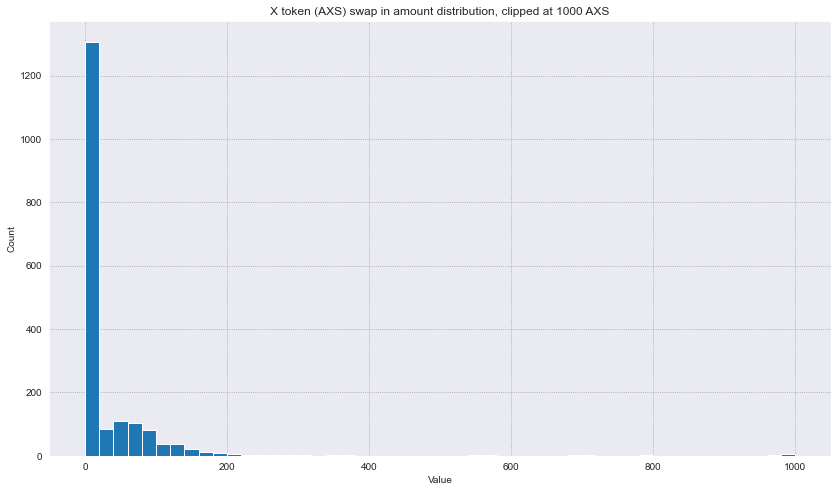

In [46]:
UPPER_LIMIT = 1000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

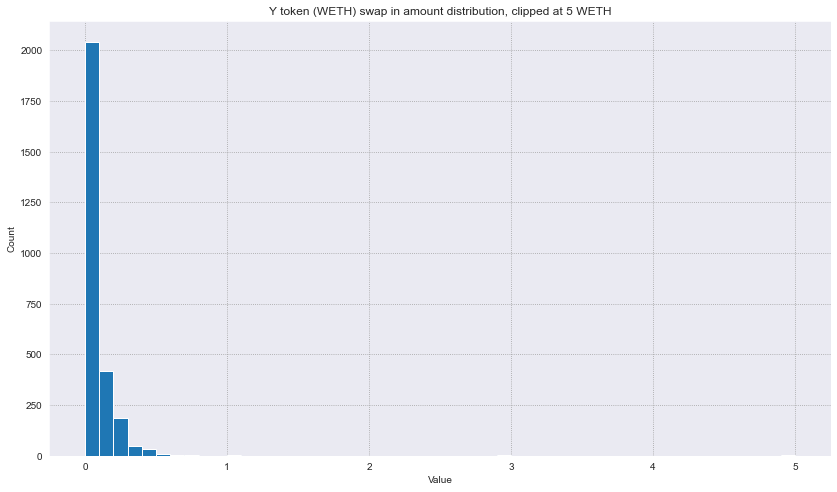

In [47]:
UPPER_LIMIT = 5

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

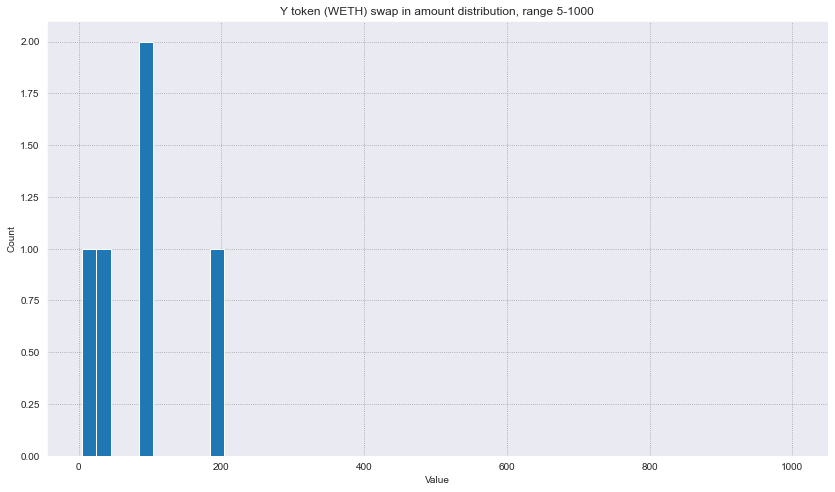

In [48]:
LOWER_LIMIT = 5
UPPER_LIMIT = 1000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

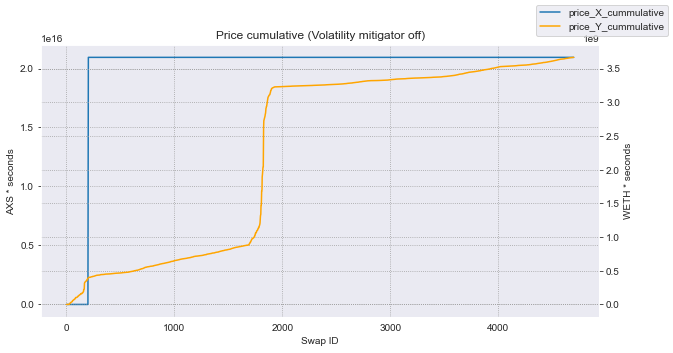

In [49]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

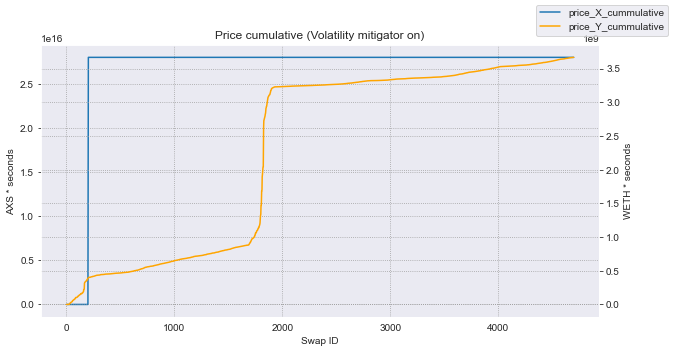

In [50]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

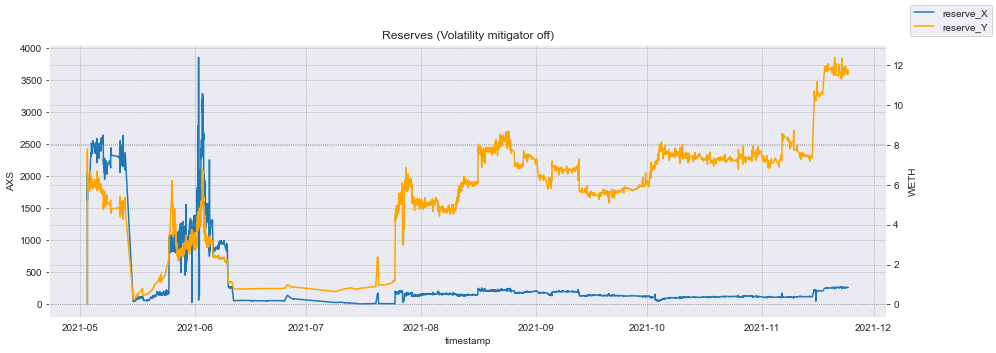

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

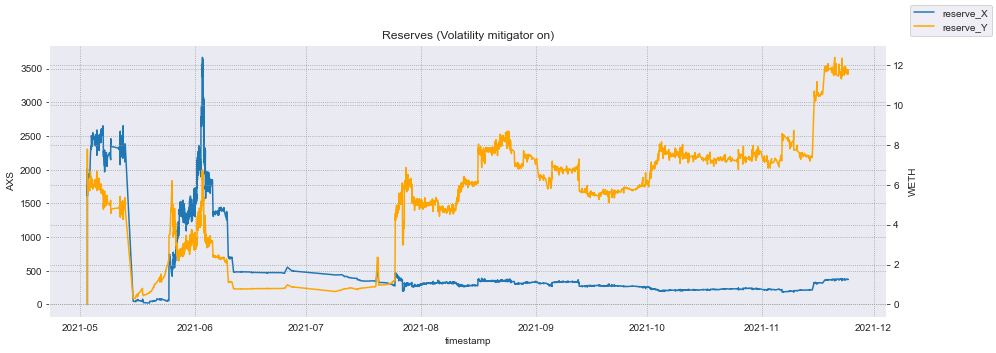

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

<ipython-input-53-fb4ab152d3f7>:3: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-53-fb4ab152d3f7>:4: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



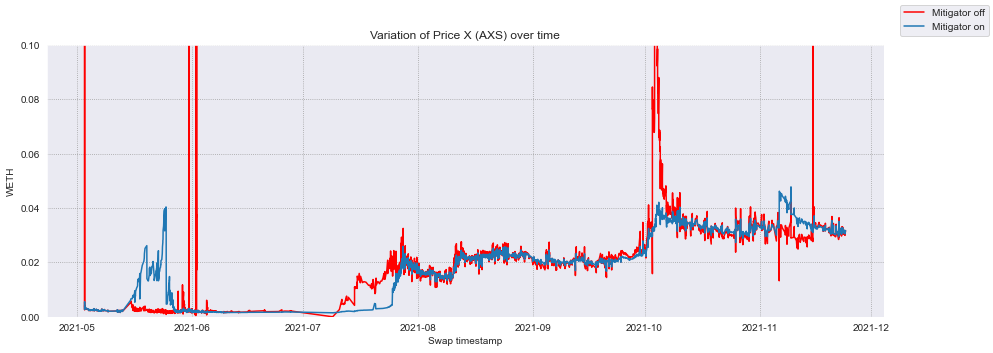

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

<ipython-input-54-88951659b433>:16: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-54-88951659b433>:17: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



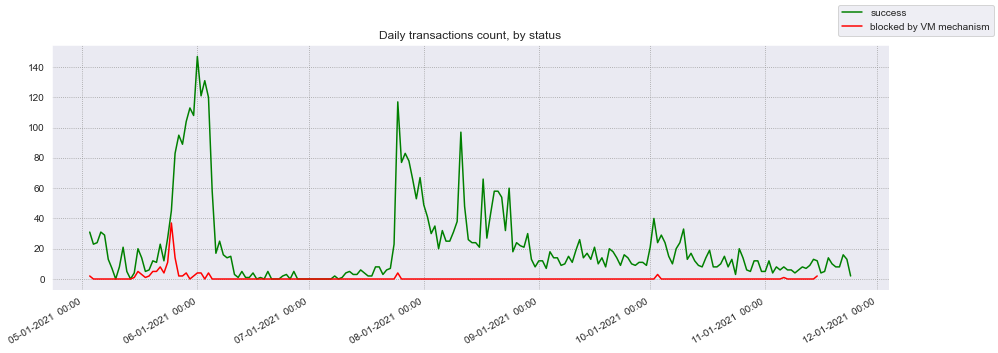

In [54]:
import matplotlib.dates as mdates
import datetime

sim1_indexed_blocked_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION']
sim1_indexed_blocked_df.index = sim1_indexed_blocked_df.transaction_timestamp
resampled_blocked = sim1_indexed_blocked_df.resample('1D').size()

sim1_indexed_success_df = swaps1_df[swaps1_df.status == 'SUCCESS']
sim1_indexed_success_df.index = sim1_indexed_success_df.transaction_timestamp
resampled_success = sim1_indexed_success_df.resample('1D').size()

#resampled_success = resampled_success[(resampled_success.index >= resampled_blocked.index.min()) & (3resampled_success.index <= resampled_blocked.index.max())]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled_success.index, y=resampled_success, linestyle='solid', marker=None, color='green', label='success')
ax.plot_date(x=resampled_blocked.index, y=resampled_blocked, linestyle='solid', marker=None, color='red', label='blocked by VM mechanism')

#ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y  %H:%M'))

fig.legend()
ax.set_title('Daily transactions count, by status')
plt.gcf().autofmt_xdate()

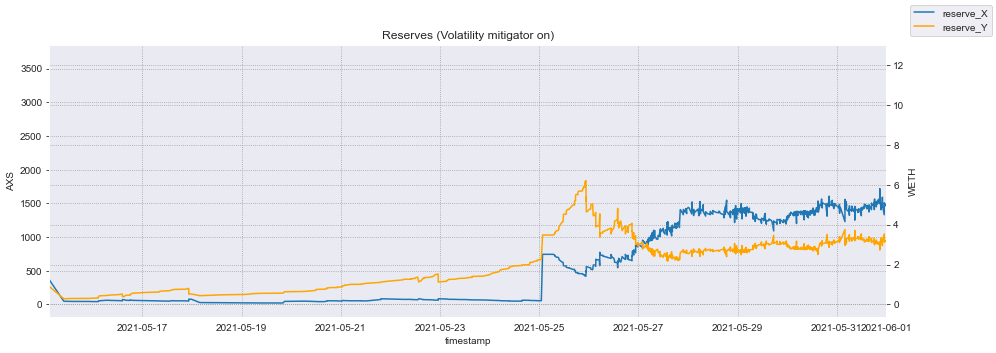

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')
ax.set_xlim(datetime.datetime(2021, 5, 15, 3, 0, 0), datetime.datetime(2021,6,1,0,0,0))

fig.legend()

In [56]:
burns0_df['Date'] = pd.to_datetime(burns0_df.transaction_timestamp, unit='s')
burns0_df[burns0_df.status != 'SUCCESS']

id     X_amount  Y_amount   timestamp   status  block_number  \
2  200  2345.853223  4.615325  1620904829  CLIPPED     108060321   

   block_timestamp  transaction_timestamp  transaction_id  reserve_X_before  \
2       1620904837             1620904829             200       2345.853223   

   reserve_Y_before      k_before  price_X_cumulative_before  \
2          4.742689  11125.652973                       2041   

   price_Y_cumulative_before  is_volatility_mitigator_on_before     reserve_X  \
2                  387608105                              False  1.000000e-12   

   reserve_Y             k  price_X_cumulative  price_Y_cumulative  \
2   0.127364  1.273643e-13                2074           395851032   

   is_volatility_mitigator_on                Date  
2                       False 2021-05-13 11:20:29

<ipython-input-57-1090fe6b6039>:3: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-57-1090fe6b6039>:4: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



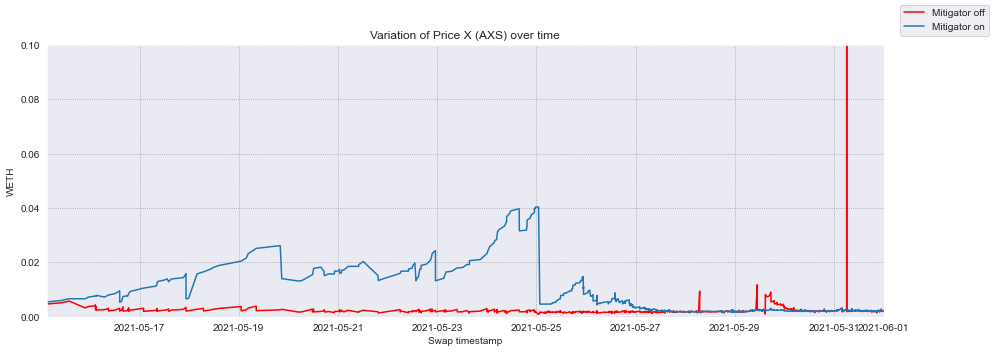

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
ax.set_xlim(datetime.datetime(2021, 5, 15, 3, 0, 0), datetime.datetime(2021,6,1,0,0,0))

fig.legend()

<ipython-input-67-03d2bffa638f>:16: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-67-03d2bffa638f>:17: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



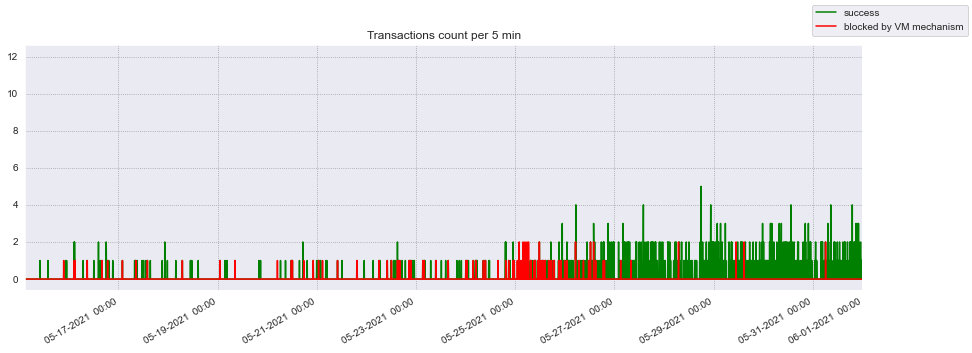

In [67]:
import matplotlib.dates as mdates
import datetime

sim1_indexed_blocked_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION']
sim1_indexed_blocked_df.index = sim1_indexed_blocked_df.transaction_timestamp
resampled_blocked = sim1_indexed_blocked_df.resample('5min').size()

sim1_indexed_success_df = swaps1_df[swaps1_df.status == 'SUCCESS']
sim1_indexed_success_df.index = sim1_indexed_success_df.transaction_timestamp
resampled_success = sim1_indexed_success_df.resample('5min').size()

#resampled_success = resampled_success[(resampled_success.index >= resampled_blocked.index.min()) & (3resampled_success.index <= resampled_blocked.index.max())]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled_success.index, y=resampled_success, linestyle='solid', marker=None, color='green', label='success')
ax.plot_date(x=resampled_blocked.index, y=resampled_blocked, linestyle='solid', marker=None, color='red', label='blocked by VM mechanism')

ax.set_xlim(datetime.datetime(2021, 5, 15, 3, 0, 0), datetime.datetime(2021,6,1,0,0,0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y  %H:%M'))

fig.legend()
ax.set_title('Transactions count per 5 min')
plt.gcf().autofmt_xdate()

In [71]:
mints1_df['Date'] = pd.to_datetime(mints1_df['timestamp'], unit='s')
#mints1_df

In [70]:
slice_df = swaps1_df[swaps1_df.transaction_timestamp >= datetime.datetime(2021, 5, 17, 3, 0, 0)]
#slice_df.head(1000)[['token_in', 'token_out', 'token_in_amount', 'status', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_X_before', 'reserve_Y_before']]#[slice_df.status != 'SUCCESS']

<ipython-input-64-0ed9873a4bba>:3: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-64-0ed9873a4bba>:4: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



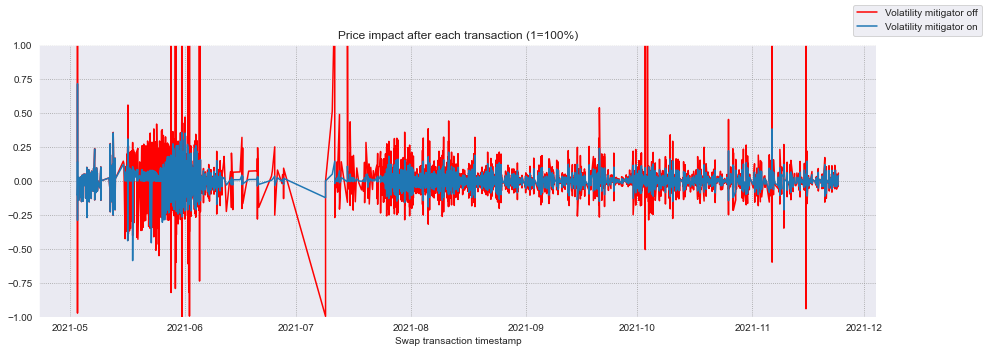

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 1)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In [62]:
slice_df = swaps1_df[swaps1_df.transaction_timestamp >= datetime.datetime(2021, 5, 15, 3, 0, 0)]
slice_df.head(1000)#[slice_df.status != 'SUCCESS']

id token_in token_out  token_in_amount  token_out_amount_min  \
195    202     WETH       AXS         0.015835             -2.767333   
196    203     WETH       AXS         0.014889             -2.335633   
197    204      AXS      WETH        14.088301             -0.070671   
198    205     WETH       AXS         0.003734             -0.549842   
199    206     WETH       AXS         0.008442             -1.194606   
200    207     WETH       AXS         0.010000             -1.334238   
201    209     WETH       AXS         0.010000             -1.329439   
202    210      AXS      WETH        14.194613             -0.081911   
203    212     WETH       AXS         0.010000             -1.326382   
204    214     WETH       AXS         0.010000             -1.351392   
205    216     WETH       AXS         0.010000             -1.354784   
206    218     WETH       AXS         0.010000             -1.344906   
207    219      AXS      WETH        18.688968             -0.104680   
208    220     WETH       AXS         0.010000             -1.282674   
209    222     WETH       AXS         0.004268             -0.588424   
210    223     WETH       AXS         0.023000             -2.989846   
211    224      AXS      WETH        16.685140             -0.103363   
212    225     WETH       AXS         0.016106             -1.927631   
213    226     WETH       AXS         0.028586             -3.128644   
214    227      AXS      WETH        18.297493             -0.129931   
215    228     WETH       AXS         0.011994             -2.151649   
216    229     WETH       AXS         0.058003             -8.827594   
217    230      AXS      WETH        26.240996             -0.135959   
218    231     WETH       AXS         0.010000             -1.301709   
219    233     WETH       AXS         0.010000             -1.323506   
220    235     WETH       AXS         0.010000             -1.332317   
221    236     WETH       AXS         0.032975             -4.047619   
222    237      AXS      WETH        25.609581             -0.139481   
223    238     WETH       AXS         0.023024             -2.547594   
224    239     WETH       AXS         0.010000             -1.043263   
225    240     WETH       AXS         0.026549             -2.602715   
226    241      AXS      WETH        24.048222             -0.164203   
227    242     WETH       AXS         0.020704             -1.876387   
228    243     WETH       AXS         0.007204             -0.624063   
229    244     WETH       AXS         0.027000             -2.217970   
230    245      AXS      WETH        22.946799             -0.198889   
231    246     WETH       AXS         0.012810             -0.990013   
232    247     WETH       AXS         0.009000             -0.673309   
233    248     WETH       AXS         0.004770             -0.349711   
234    249     WETH       AXS         0.009000             -0.646757   
235    251     WETH       AXS         0.014154             -1.103242   
236    252      AXS      WETH        20.115300             -0.190280   
237    253     WETH       AXS         0.027000             -1.990352   
238    254     WETH       AXS         0.013257             -0.926147   
239    255     WETH       AXS         0.039306             -2.568140   
240    256      AXS      WETH        28.101766             -0.263220   
241    257     WETH       AXS         0.008260             -1.222400   
242    259     WETH       AXS         0.017770             -1.159719   
243    260     WETH       AXS         0.010000             -0.612582   
244    261      AXS      WETH        12.362731             -0.139533   
245    262     WETH       AXS         0.016025             -0.927252   
246    263     WETH       AXS         0.005582             -0.308273   
247    264     WETH       AXS         0.010000             -0.534493   
248    265     WETH       AXS         0.019772             -0.994486   
249    266      AXS      WETH        17.205360  

In [68]:
#swaps1_df[swaps1_df.transaction_timestamp >= datetime.datetime(2021, 5, 13, 3, 0, 0)].head(1000)[['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'transaction_timestamp', 'status', 'slice_factor', 'slice_factor_curve', 'oracle_amount_out', 'out_amount_diff', 'reserve_X_before', 'reserve_Y_before', 'X_price']]

In [69]:
slice_df = swaps0_df[swaps0_df.transaction_timestamp >= datetime.datetime(2021, 5, 15, 3, 0, 0)]
#slice_df.head(1000)#[slice_df.status != 'SUCCESS']

In [182]:
slice_df = swaps0_df[swaps0_df.transaction_timestamp >= datetime.datetime(2021, 5, 15, 3, 0, 0)]
slice_df.loc[982]

id                                                                                1012
token_in                                                                          WETH
token_out                                                                          AXS
token_in_amount                                                              98.999966
token_out_amount_min                                                               0.0
token_out_amount                                                           1180.340102
system_fee                                                                       0.396
mitigator_check_status                                                   MITIGATOR_OFF
oracle_amount_out                                                                  NaN
out_amount_diff                                                                    NaN
slice_factor                                                                       NaN
slice_factor_curve                         

**Almost all of the swaps with a significant price impact are blocked by the volatility mitigation mechanism**

Below is shown the information about the swaps with a price impact greater than 25%, not blocked by the volatility mitigation:

In [77]:
swaps0_df[swaps0_df.price_diff > 0.75] #.tail(3).at[4499, 'txd']

id token_in token_out  token_in_amount  token_out_amount_min  \
2        3     WETH       AXS       200.000000                   0.0   
11      12     WETH       AXS         1.710000                   0.0   
674    703     WETH       AXS         2.617447                   0.0   
798    827     WETH       AXS         2.922807                   0.0   
817    846     WETH       AXS         2.922162                   0.0   
982   1012     WETH       AXS        98.999966                   0.0   
1190  1222     WETH       AXS         1.071718                   0.0   
1193  1225     WETH       AXS         1.161828                   0.0   
1229  1262     WETH       AXS        98.999966                   0.0   
1253  1286     WETH       AXS        36.524902                   0.0   
1598  1637     WETH       AXS         2.104349                   0.0   
1601  1640     WETH       AXS         2.554795                   0.0   
1782  1833     WETH       AXS         0.052275                   0.0   
1795  1848     WETH       AXS         0.039375                   0.0   
3979  4074     WETH       AXS         3.034927                   0.0   
3997  4092     WETH       AXS         2.746278                   0.0   
4427  4527     WETH       AXS         1.274128                   0.0   
4499  4600     WETH       AXS        22.403374                   0.0   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
2          1694.606685    0.800000          MITIGATOR_OFF                NaN   
11          502.082446    0.006840          MITIGATOR_OFF                NaN   
674         617.549487    0.010470          MITIGATOR_OFF                NaN   
798         539.322196    0.011691          MITIGATOR_OFF                NaN   
817        1007.748956    0.011689          MITIGATOR_OFF                NaN   
982        1180.340102    0.396000          MITIGATOR_OFF                NaN   
1190        874.045919    0.004287          MITIGATOR_OFF                NaN   
1193       1009.363595    0.004647          MITIGATOR_OFF                NaN   
1229       3783.403821    0.396000          MITIGATOR_OFF                NaN   
1253        485.674951    0.146100          MITIGATOR_OFF                NaN   
1598        632.546074    0.008417          MITIGATOR_OFF                NaN   
1601       1406.142084    0.010219          MITIGATOR_OFF                NaN   
1782         12.536271    0.000209          MITIGATOR_OFF                NaN   
1795          5.736891    0.000158          MITIGATOR_OFF                NaN   
3979         86.952530    0.012140          MITIGATOR_OFF                NaN   
3997         24.909891    0.010985          MITIGATOR_OFF                NaN   
4427         62.026122    0.005097          MITIGATOR_OFF                NaN   
4499        171.837170    0.089613          MITIGATOR_OFF                NaN   

      out_amount_diff  slice_factor  slice_factor_curve   status  \
2                 NaN           NaN                 NaN  SUCCESS   
11                NaN           NaN                 NaN  SUCCESS   
674               NaN           NaN                 NaN  SUCCESS   
798               NaN           NaN                 NaN  SUCCESS   
817               NaN           NaN                 NaN  SUCCESS   
982               NaN           NaN                 NaN  SUCCESS   
1190              NaN           NaN                 NaN  SUCCESS   
1193              NaN           NaN                 NaN  SUCCESS   
1229              NaN           NaN                 NaN  SUCCESS   
1253              NaN           NaN                 NaN  SUCCESS   
1598              NaN           NaN                 NaN  SUCCESS   
1601              NaN           NaN                 NaN  SUCCESS   
1782              NaN           NaN                 NaN  SUCCESS   
1795              NaN           NaN                 NaN  SUCCESS   
3979              NaN           NaN                 NaN  SUCCESS   
3997              NaN         

In [193]:
swaps1_df[swaps1_df.price_diff > 0.25]

id token_in token_out  token_in_amount  token_out_amount_min  \
11      12     WETH       AXS         1.710000                   0.0   
165    170     WETH       AXS         0.617435                   0.0   
187    192     WETH       AXS         0.700000                   0.0   
216    229     WETH       AXS         0.058003                   0.0   
711    740     WETH       AXS         0.308515                   0.0   
824    853     WETH       AXS         0.380000                   0.0   
873    902     WETH       AXS         0.350139                   0.0   
936    966     WETH       AXS         0.421922                   0.0   
969    999     WETH       AXS         0.533741                   0.0   
1054  1084     WETH       AXS         0.390000                   0.0   
1084  1114     WETH       AXS         0.508411                   0.0   
1169  1201     WETH       AXS         0.500000                   0.0   
1467  1506     WETH       AXS         0.387448                   0.0   
4427  4527     WETH       AXS         1.274128                   0.0   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
11          470.430914    0.006840                CHECKED         459.609537   
165         264.148931    0.002470                CHECKED         296.024060   
187         371.206700    0.002800                CHECKED         341.881764   
216           8.827594    0.000232                CHECKED           8.424154   
711         175.318013    0.001234                CHECKED         160.652524   
824         132.937555    0.001520                CHECKED         181.994878   
873         147.460169    0.001401                CHECKED         153.102748   
936         177.767364    0.001688                CHECKED         200.976774   
969         201.578637    0.002135                CHECKED         258.413561   
1054        213.247043    0.001560                CHECKED         176.811190   
1084        212.070808    0.002034                CHECKED         239.401563   
1169        232.796191    0.002000                CHECKED         254.837101   
1467        192.593763    0.001550                CHECKED         215.916390   
4427         32.793486    0.005097                CHECKED          38.661343   

      out_amount_diff  slice_factor  slice_factor_curve   status  \
11                2.0          31.0                98.0  SUCCESS   
165              11.0          13.0                39.0  SUCCESS   
187               8.0          17.0                68.0  SUCCESS   
216               4.0          15.0                45.0  SUCCESS   
711               8.0          13.0                39.0  SUCCESS   
824              31.0          13.0                39.0  SUCCESS   
873               3.0          13.0                39.0  SUCCESS   
936              12.0          14.0                42.0  SUCCESS   
969              24.0          17.0                68.0  SUCCESS   
1054             18.0          15.0                45.0  SUCCESS   
1084             12.0          17.0                68.0  SUCCESS   
1169              9.0          13.0                39.0  SUCCESS   
1467             11.0          13.0                39.0  SUCCESS   
4427             16.0          18.0                72.0  SUCCESS   

      block_number     block_timestamp transaction_timestamp  \
11               6 2021-05-03 01:43:52   2021-05-03 01:43:46   
165          50890 2021-05-11 21:44:52   2021-05-11 21:44:38   
187          55458 2021-05-12 16:46:52   2021-05-12 16:46:49   
216          78313 2021-05-16 16:00:37   2021-05-16 16:00:33   
711         148088 2021-05-28 18:44:22   2021-05-28 18:44:20   
824         153550 2021-05-29 17:29:52   2021-05-29 17:29:48   
873         156202 2021-05-30 04:32:52   2021-05-30 04:32:40   
936         159758 2021-05-30 19:21:52   2021-05-30 19:21:40   
969         161828 2021-05-31 03:59:22   2021-05-31 03:59:10   
1054        165879 2021-05-31 20:52:07   2021-05-31 20:51:57   
1

<ipython-input-63-ded93a1082b4>:3: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

<ipython-input-63-ded93a1082b4>:4: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



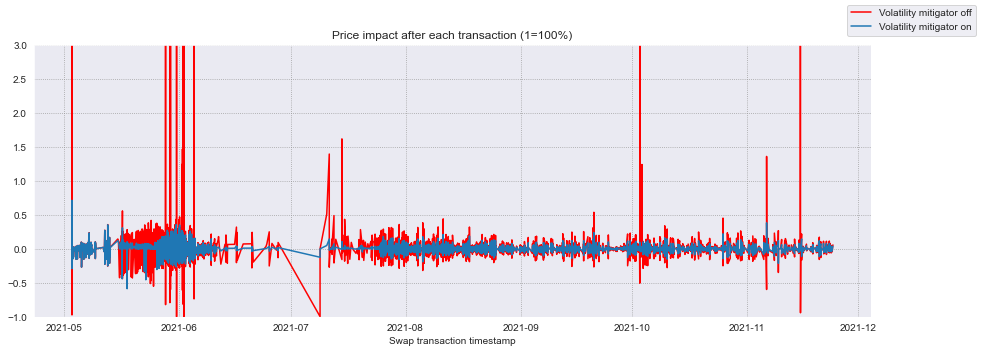

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()